# Optimizing a Small Power Network with PyPSA

This notebook demonstrates the use of **PyPSA** (*Python for Power System Analysis*) to model and optimize a small multi-node power network, 
analyze the impact of congestion, and study how storage affects nodal prices.

**Objectives:**
- Build a small 3-node network with solar, wind, and gas generation.
- Simulate 24 hours of operation with and without storage.
- Compare dispatch results and nodal prices.



## 0) Setup

If needed, install dependencies:
```bash
pip install pypsa pandas numpy matplotlib
```
Then run the cells **top to bottom**.


In [ ]:
import pypsa
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from IPython.display import display

plt.rcParams['figure.figsize'] = (10,5)  # single-plot figures, no custom colors per project rules

def summarize_run(net, label):
    """Return a small summary Series for comparisons."""
    s = pd.Series(name=label, dtype=float)
    s['total_cost'] = float(net.objective)
    if 'Gas_C' in net.generators.index:
        s['gas_MWh'] = float(net.generators_t.p['Gas_C'].sum())
    # Per-bus mean and std for quick inspection
    for b in net.buses.index:
        s[f'mean_price_{b}'] = float(net.buses_t.marginal_price[b].mean())
        s[f'std_price_{b}'] = float(net.buses_t.marginal_price[b].std())
    return s

def plot_generation_stack(net, title):
    ax = net.generators_t.p.plot.area()
    ax.set_title(title)
    ax.set_ylabel("MW")
    ax.set_xlabel("Time")
    plt.show()

def plot_nodal_prices(net, title):
    ax = net.buses_t.marginal_price.plot()
    ax.set_title(title)
    ax.set_ylabel("S$/MWh")
    ax.set_xlabel("Time")
    plt.show()

## 1) Create the network 

In [ ]:
def create_network():
    network = pypsa.Network(name="small network")

    # Define 24-hour snapshots 
    hours = pd.date_range("2025-08-11T00:00", periods=24, freq="h")
    network.set_snapshots(hours)

    # Add Buses 
    network.add("Bus", "A", carrier="AC")  # Solar
    network.add("Bus", "B", carrier="AC")  # Wind
    network.add("Bus", "C", carrier="AC")  # Gas + Load

    # add Lines
    network.add("Line", "A-B", bus0="A", bus1="B", length=100, s_nom=60, carrier="AC", r=0.01, x=0.1)
    network.add("Line", "B-C", bus0="B", bus1="C", length=150, s_nom=60, carrier="AC", r=0.01, x=0.1)
    network.add("Line", "A-C", bus0="A", bus1="C", length=200, s_nom=40, carrier="AC", r=0.02, x=0.15)  

    # Load at C (evening peak)
    load_profile = 50 + 10 * np.sin(np.linspace(0, 2*np.pi, 24) - 9/8 * np.pi)
    network.add("Load", "Load_C", bus="C", p_set=load_profile)

    # Solar at A (daylight hours only)
    solar_profile = np.zeros(24)
    solar_profile[6:20] = np.sin(np.linspace(0, np.pi, 14))
    network.add("Generator", "Solar_A", bus="A", p_nom=50, p_max_pu=solar_profile, marginal_cost=10.0)

    # Wind at B 
    wind_profile = 0.5 + 0.5*np.sin(np.linspace(0, 3*np.pi, 24))
    wind_profile = np.clip(wind_profile, 0.0, 1.0)
    network.add("Generator", "Wind_B", bus="B", p_nom=40, p_max_pu=wind_profile, marginal_cost=15.0)

    # Gas at C (pilotable, more expensive)
    network.add("Generator", "Gas_C", bus="C", p_nom=100, marginal_cost=50.0)

    return network

net_base = create_network()
net_base

PyPSA Network 'small network'
-----------------------------
Components:
 - Bus: 3
 - Generator: 3
 - Line: 3
 - Load: 1
Snapshots: 24

## 2) Baseline (no storage) 

Index(['A-B', 'B-C', 'A-C'], dtype='object', name='Line')


Index(['A', 'B', 'C'], dtype='object', name='Bus')
INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.io: Writing time: 0.03s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 144 primals, 384 duals
Objective: 2.43e+04
Solver model: available
Solver message: Optimal

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Line-fix-s-lower, Line-fix-s-upper, Kirchhoff-Voltage-Law were not assigned to the network.


objective_cost    24252.652706
gas_MWh             235.266921
mean_price_A         36.458333
std_price_A          17.905499
mean_price_B         36.458333
std_price_B          17.905499
mean_price_C         36.458333
std_price_C          17.905499
Name: Baseline, dtype: float64

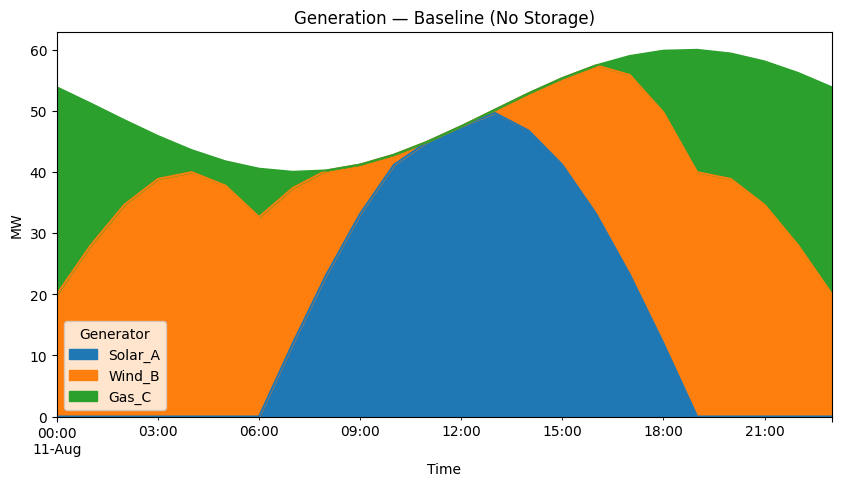

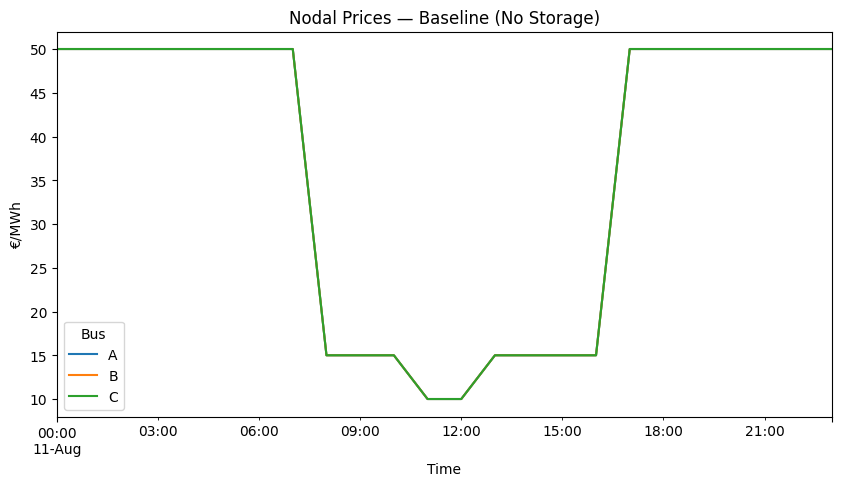

In [8]:
net_base = net_base.copy()  # explicit copy for clarity
net_base.optimize()

summary_base = summarize_run(net_base, "Baseline")
display(summary_base)

plot_generation_stack(net_base, "Generation — Baseline (No Storage)")
plot_nodal_prices(net_base, "Nodal Prices — Baseline (No Storage)")

## 3) With storage 

Index(['A-B', 'B-C', 'A-C'], dtype='object', name='Line')
Index(['A', 'B', 'C'], dtype='object', name='Bus')
INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.io: Writing time: 0.07s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 216 primals, 552 duals
Objective: 2.37e+04
Solver model: available
Solver message: Optimal

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Line-fix-s-lower, Line-fix-s-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, Kirchhoff-Voltage-Law, StorageUnit-energy_balance were not assigned to the network.


objective_cost    23681.350624
gas_MWh             217.693063
mean_price_A         47.495000
std_price_A           3.303496
mean_price_B         47.495000
std_price_B           3.303496
mean_price_C         47.495000
std_price_C           3.303496
Name: With_Storage, dtype: float64

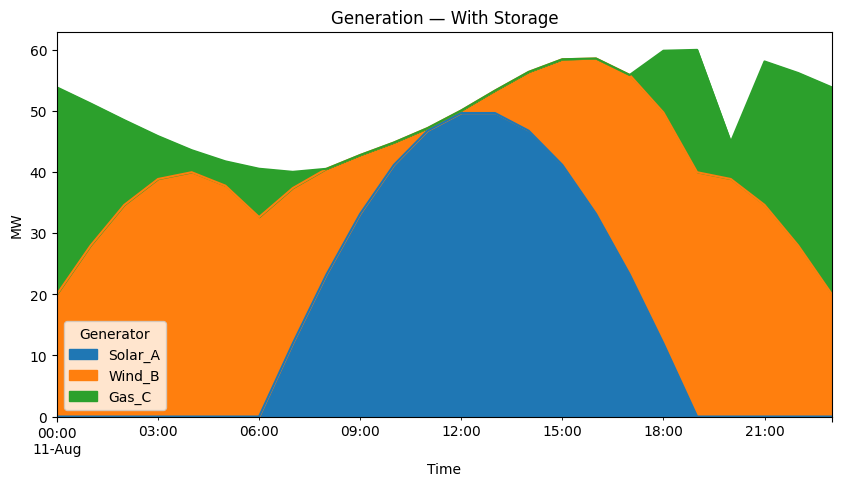

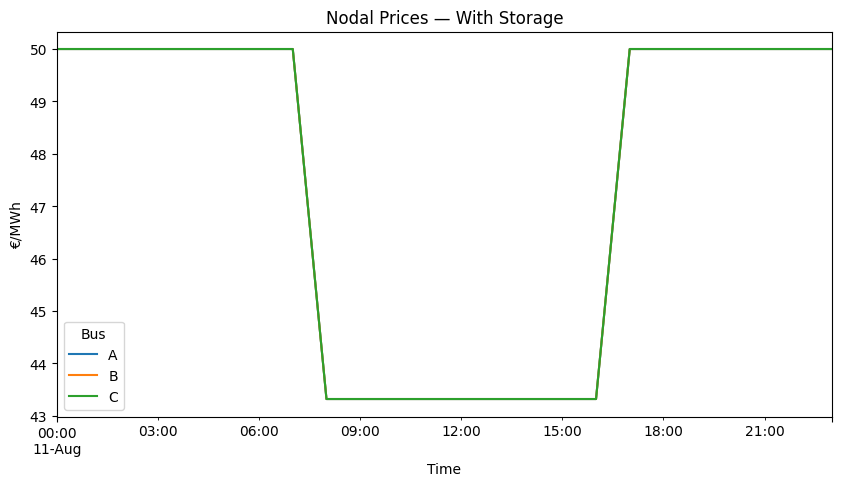

In [ ]:
net_store = create_network()

# Simple, realistic battery at demand node C
net_store.add("StorageUnit", "Battery_C",
              bus="C",
              p_nom=30.0,   # MW charge/discharge limit
              e_nom=100.0,  # MWh capacity
              efficiency_store=0.95,
              efficiency_dispatch=0.95,
              standing_loss=0.0,
              marginal_cost=2.0,   # small cycling cost (degradation/ops)
              e_initial=20.0) # 20% initial SOC

net_store.optimize()

summary_store = summarize_run(net_store, "With_Storage")
display(summary_store)

plot_generation_stack(net_store, "Generation — With Storage")
plot_nodal_prices(net_store, "Nodal Prices — With Storage")

## 4) Side-by-side comparison (cost, gas, prices)

In [10]:
summary = pd.concat([summary_base, summary_store], axis=1)
summary

,Baseline,With_Storage
objective_cost,24252.652706,23681.350624
gas_MWh,235.266921,217.693063
mean_price_A,36.458333,47.495000
std_price_A,17.905499,3.303496
mean_price_B,36.458333,47.495000
std_price_B,17.905499,3.303496
mean_price_C,36.458333,47.495000
std_price_C,17.905499,3.303496


## 5) Conclusion

In this simplified 3-node network model:

- **Total system cost** fell from **€24,252.65** to **S$23,681.35** (↓ 2.35%).
- **Gas usage** fell from **235.27 MWh** to **217.69 MWh** (↓ 7.5%).
- **Price volatility** (standard deviation of LMPs) dropped by **81%** (from ~17.91 S$/MWh to ~3.30 S$/MWh).

**Interpretation:**  
The battery reduced reliance on expensive gas and smoothed price spikes, even though the average marginal price rose.  
Storage allowing the usage of solar energy even during evening peak hours show that flexibility supports decarbonisation while optimising system costs.